In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix,mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import xgboost as xgb
from functools import reduce
%matplotlib inline

In [2]:
df=pd.read_csv(r"D:\ML\xgboost_test\customer_churn_dataset.csv")

In [3]:
df.columns=df.columns.str.replace(" ","_",regex=True)
df.columns

Index(['Unnamed:_0', 'Customer_ID', 'demo_count', 'Country', 'State', 'City',
       'Zip_Code', 'Lat_Long', 'Latitude', 'Longitude', 'Gender',
       'Senior_Citizen', 'Dependents', 'Tenure_in_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection_Plan', 'Premium_Tech_Support',
       'Streaming_TV', 'Streaming_Movies', 'Contract', 'Paperless_Billing',
       'Payment_Method', 'Monthly_Charge', 'Total_Charges', 'Churn_Label',
       'Churn_Value', 'Churn_Score', 'CLTV', 'Churn_Reason'],
      dtype='object')

In [4]:
def drop_constants(df,col_list=['Customer_ID','Unnamed:_0']):
    col_list.extend([x for x in list(df.columns) if df[x].nunique()==1])
    print(f"dropping consant cols: {col_list} ")
    df.drop(columns=col_list,inplace=True)
    return df


In [5]:
#dropping ids cols, constant and quasi constant cols
df=drop_constants(df)

dropping consant cols: ['Customer_ID', 'Unnamed:_0', 'demo_count', 'Country', 'State'] 


In [6]:
df.drop('Lat_Long',axis=1, inplace=True)

In [7]:
df['City'].replace(" ","_", regex=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   City                    7043 non-null   object 
 1   Zip_Code                7043 non-null   int64  
 2   Latitude                7043 non-null   float64
 3   Longitude               7043 non-null   float64
 4   Gender                  7043 non-null   object 
 5   Senior_Citizen          7043 non-null   object 
 6   Dependents              7043 non-null   object 
 7   Tenure_in_Months        7043 non-null   int64  
 8   Phone_Service           7043 non-null   object 
 9   Multiple_Lines          7043 non-null   object 
 10  Internet_Service        7043 non-null   object 
 11  Online_Security         7043 non-null   object 
 12  Online_Backup           7043 non-null   object 
 13  Device_Protection_Plan  7043 non-null   object 
 14  Premium_Tech_Support    7043 non-null   

In [9]:
categorical_cols=df.select_dtypes(include="object").columns.to_list()
categorical_cols

['City',
 'Gender',
 'Senior_Citizen',
 'Dependents',
 'Phone_Service',
 'Multiple_Lines',
 'Internet_Service',
 'Online_Security',
 'Online_Backup',
 'Device_Protection_Plan',
 'Premium_Tech_Support',
 'Streaming_TV',
 'Streaming_Movies',
 'Contract',
 'Paperless_Billing',
 'Payment_Method',
 'Churn_Label',
 'Churn_Reason']

In [10]:
df['Churn_Label'].value_counts()

Churn_Label
No     5174
Yes    1869
Name: count, dtype: int64

In [11]:
df.groupby(['Churn_Label','Paperless_Billing']).agg({'Paperless_Billing':'count'})

Paperless_Billing
Churn_Label Paperless_Billing                   
No          No                              2403
            Yes                             2771
Yes         No                               469
            Yes                             1400

In [12]:
def get_stacked_plots(columns,super_title):
   cols = 2
   rows=len(columns)//2
   
   #creating a figure 
   fig = plt.figure(figsize=(12,6*rows))
   fig.suptitle(super_title, fontsize=10)


   #iterating each col to be plotted along with index
   for idx,col in enumerate(columns,1):
      axes=fig.add_subplot(rows,cols,idx)

      #feature_proportion = pd.pivot_table(df,index=col,columns='Churn_Label',aggfunc={'Churn_Label':lambda x : len(x)/len(df['Churn_Label'])*100})
      feature_proportion = pd.crosstab(index=df[col], columns=df['Churn_Label'], normalize="index")
      feature_proportion.plot(kind='bar',ax=axes,stacked=True)
      axes.set_title(f"proportion of observations w.r.t {col}")


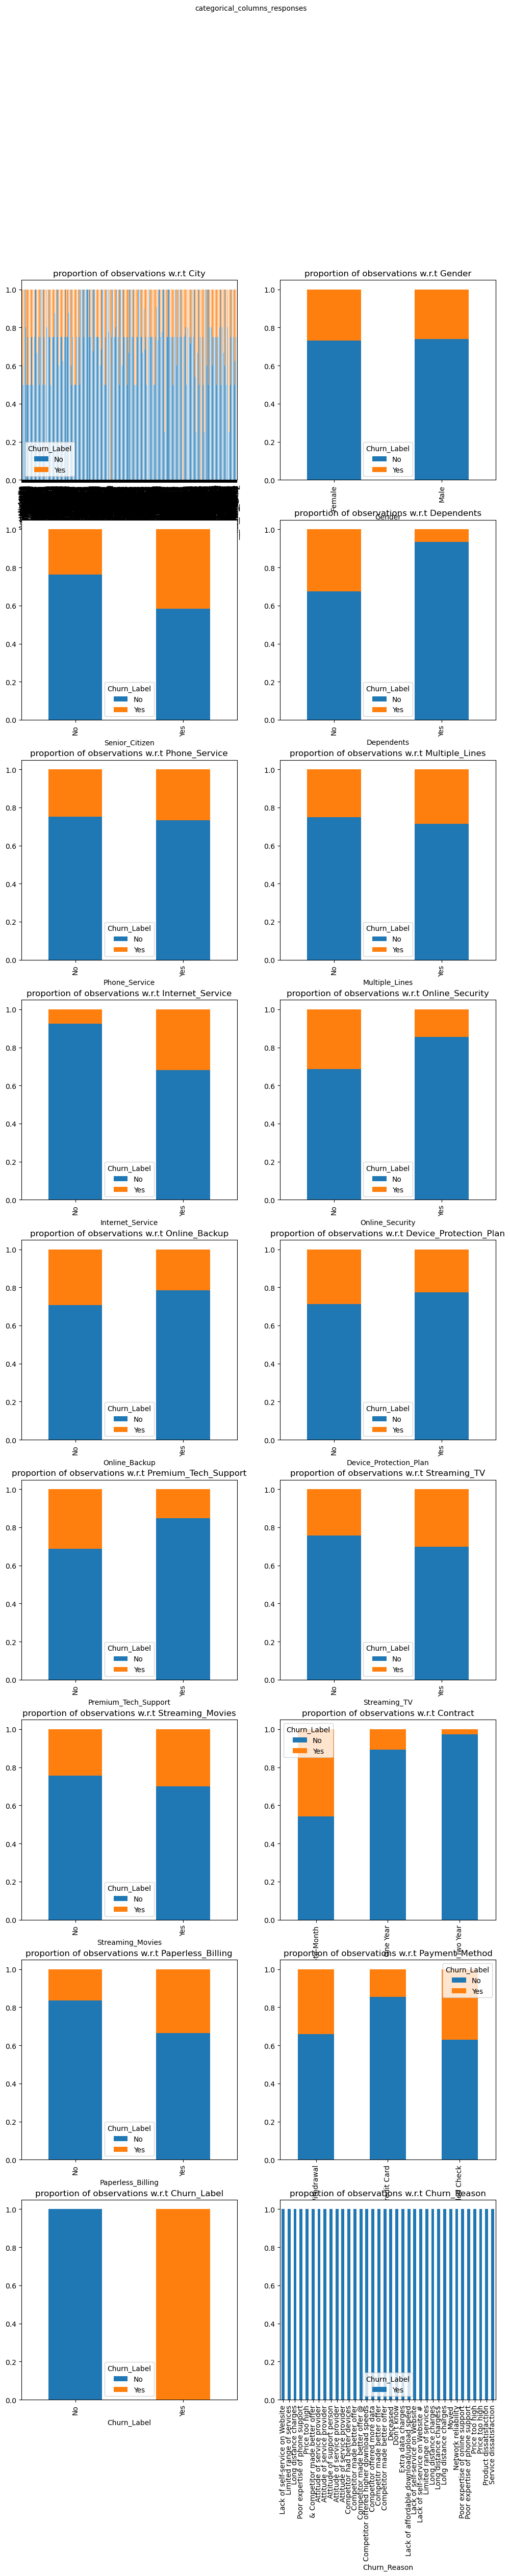

In [13]:
get_stacked_plots(categorical_cols,"categorical_columns_responses")

### Observations for categorical features
1. Paperless Billing - people with paperless billing tend to churn more
2. Contract - People with monthly contract tend to churn more compared to others
3. Dependents - people who have dependents churn less 
4. Internet service - people with internet service churn more compared to others.
5. Payment_Method -  people paying using check or cash churn more.
6. Online_Security - people not haivng online security churn more.


In [14]:
numerical_features = list(df.select_dtypes(include="number").columns)
numerical_features.remove('CLTV')

In [15]:
def get_hist_numerical_cols(columns, super_title):
    cols=2
    rows= len(columns)//2
    
    #creating figure
    fig=plt.figure(figsize=(12,5*rows))
    fig.suptitle(super_title,fontsize=10)

    for idx,col in enumerate(columns,1):
        axes=fig.add_subplot(rows,cols,idx)

        df[df['Churn_Label']=="No"][col].plot(kind='hist',ax=axes,density=True, alpha=0.5, label='No')
        df[df['Churn_Label']=="Yes"][col].plot(kind='hist',ax=axes,density=True, alpha=0.5, label='Yes')
        axes.legend(loc='upper right',title='churn',fancybox=True)
        axes.set_title(f"distribution of {col} by churn")

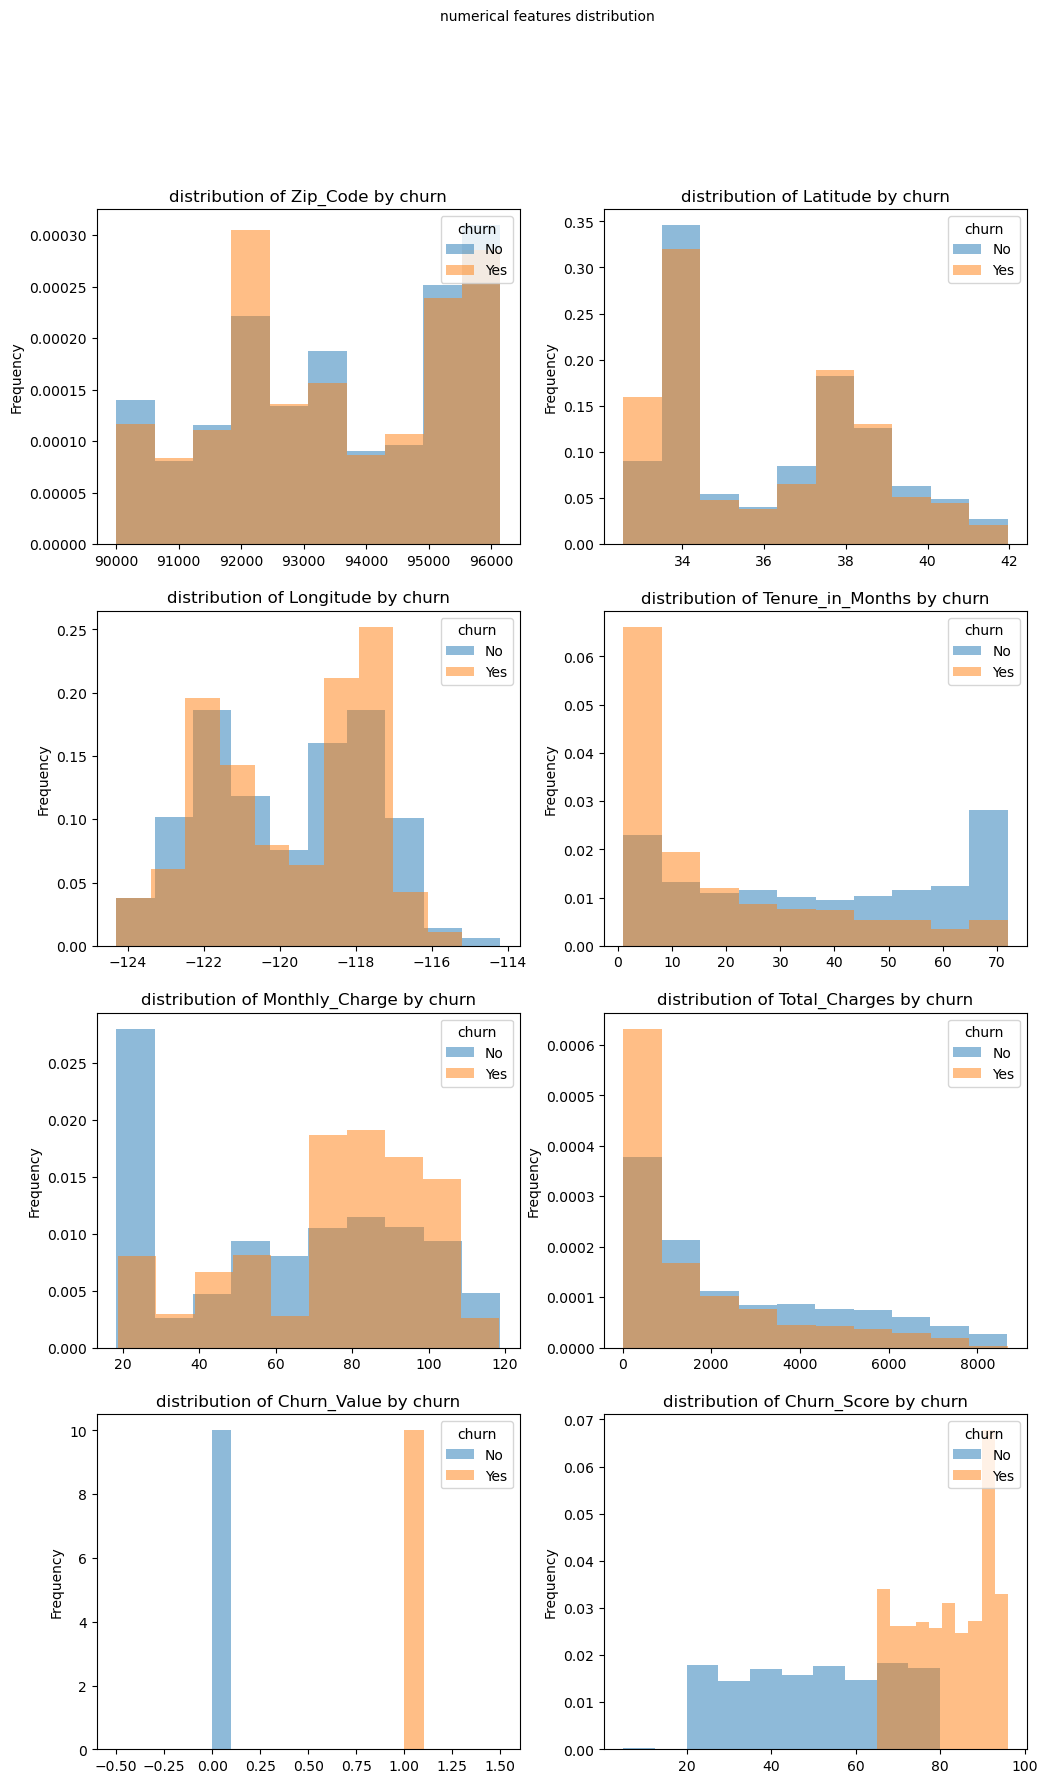

In [16]:
get_hist_numerical_cols(numerical_features,"numerical features distribution")

### Observations for numerical features
1. new customer i.e low in tenure are likely to churn.
2. Churn is high when the monthly charges are high.
3. clients with low total charges churn more.

## feature importance

In [17]:
def calc_mutual_info(cat_feature):
    return mutual_info_score(cat_feature,df['Churn_Label'])

#extracting all the categorical features form the dataframe
cat_features=df.select_dtypes(include='object').drop(['Churn_Label','Churn_Reason'], axis=1)

feature_importance=cat_features.apply(calc_mutual_info).sort_values(ascending=True)

print(feature_importance)



Gender                    0.000037
Phone_Service             0.000072
Multiple_Lines            0.000801
Streaming_Movies          0.001868
Streaming_TV              0.001981
Device_Protection_Plan    0.002228
Online_Backup             0.003460
Senior_Citizen            0.010577
Premium_Tech_Support      0.014608
Online_Security           0.015885
Paperless_Billing         0.019194
Payment_Method            0.025417
Internet_Service          0.031370
Dependents                0.037746
City                      0.117160
Contract                  0.118437
dtype: float64


# feature engineering

In [18]:
df.apply(lambda col: ', '.join(map(str, col.unique())))

City                      Los_Angeles, Inglewood, Whittier, Pico_Rivera,...
Zip_Code                  90022, 90063, 90065, 90303, 90602, 90660, 9072...
Latitude                  34.02381, 34.044271, 34.108833, 33.936291, 33....
Longitude                 -118.156582, -118.185237, -118.229715, -118.33...
Gender                                                         Male, Female
Senior_Citizen                                                      Yes, No
Dependents                                                          No, Yes
Tenure_in_Months          1, 8, 18, 25, 37, 27, 58, 15, 7, 11, 3, 13, 16...
Phone_Service                                                       No, Yes
Multiple_Lines                                                      No, Yes
Internet_Service                                                    Yes, No
Online_Security                                                     No, Yes
Online_Backup                                                       No, Yes
Device_Prote

# Feature engineering

In [2]:
feature_list=['Senior_Citizen','Dependents','Tenure_in_Months','Premium_Tech_Support','Monthly_Charge','Total_Charges','Online_Security','Paperless_Billing','Payment_Method','Internet_Service','Dependents','Churn_Value']

In [ ]:
ndf=df[df[feature_list]]

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder